In [ ]:
# Import delle librerie richieste
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import os
from matplotlib import pyplot as plt
import numpy as np
from torchvision import datasets, transforms
import torchvision
import itertools
from sklearn.metrics import confusion_matrix

### Caricamento del Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Directory locale del tuo progetto
project_dir = os.getcwd()

In [ ]:
# Directory principale del tuo progetto AB
project_dir = '/content/gdrive/MyDrive/Progetto Computer Vision'

In [ ]:
# Directory principale del tuo progetto Waltico
project_dir = '/content/gdrive/My Drive/Progetto Computer Vision/'

In [ ]:
# Directory principale del tuo progetto Giansimone
project_dir = '/content/gdrive/MyDrive/Colab Notebooks/Computer Vision e Deep Learning/Progetto Computer Vision'

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
# Percorsi delle cartelle del dataset
data_dir = os.path.join(project_dir, 'data/dataset/Armocromia/ARMOCROMIA 2. TEST_TRAIN')
batch_size = 32

# Creazione degli ImageFolder per il training e il testing
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'TRAIN'), data_transforms['train']),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'TEST'), data_transforms['test']),
}

# Creazione dei DataLoader
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=2),
    'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=2),
}

# Numero di classi (armocromia)
num_classes = len(image_datasets['train'].classes)
print(num_classes)

4


Verifica train set:
Numero di immagini: 1774
Numero di classi: 4
Classi: ['autunno', 'estate', 'inverno', 'primavera']
Dimensioni batch: torch.Size([64, 3, 224, 224])
Etichette batch: tensor([0, 3, 0, 1, 0, 2, 3, 3, 1, 2, 0, 0, 3, 1, 3, 1, 2, 2, 2, 1, 1, 3, 3, 0,
        1, 3, 1, 1, 1, 3, 1, 3, 0, 2, 2, 3, 0, 3, 2, 1, 3, 3, 0, 1, 1, 3, 2, 2,
        0, 0, 3, 2, 3, 1, 0, 1, 1, 1, 2, 1, 1, 3, 3, 3])


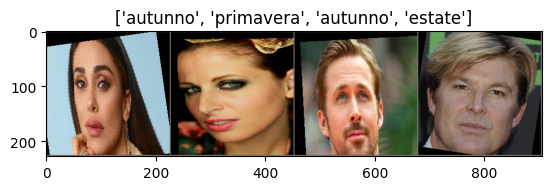

Verifica test set:
Numero di immagini: 705
Numero di classi: 4
Classi: ['autunno', 'estate', 'inverno', 'primavera']
Dimensioni batch: torch.Size([64, 3, 224, 224])
Etichette batch: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


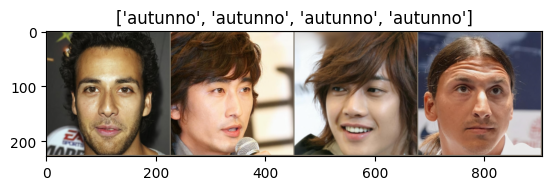

In [ ]:
# Funzione per visualizzare un tensor di immagini
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.show()

def verify_dataloaders(dataloaders):
    for phase in ['train', 'test']:
        print(f"Verifica {phase} set:")
        dataset = dataloaders[phase].dataset
        print(f"Numero di immagini: {len(dataset)}")
        print(f"Numero di classi: {len(dataset.classes)}")
        print(f"Classi: {dataset.classes}")

        # Controlla alcune immagini
        data_iter = iter(dataloaders[phase])
        images, labels = next(data_iter)
        print(f"Dimensioni batch: {images.size()}")
        print(f"Etichette batch: {labels}")

        # Visualizza alcune immagini
        out = torchvision.utils.make_grid(images[:4])
        imshow(out, title=[dataset.classes[x] for x in labels[:4]])

# Chiamata alla funzione di verifica dei dataloaders
verify_dataloaders(dataloaders)

### Definizione del modello ResNET50 e modifica dell'ultimo stato

In [ ]:
# Caricamento del modello ResNet-50 pre-addestrato
model = models.resnet50(pretrained=True)

# Congelamento dei parametri iniziali
for param in model.parameters():
    param.requires_grad = False

# Scongelamento dei parametri degli ultimi layer
for param in model.layer4.parameters():
    param.requires_grad = True

# Modifica del layer finale per adattarlo al numero di classi dell'armocromia
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)

# Spostamento del modello sulla GPU se disponibile
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0


### Early stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_loss = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.best_loss = val_loss

### Definizione della loss function e dell'ottimizzatore

In [ ]:
# Definizione della loss function (CrossEntropy) e dell'ottimizzatore (Adam)
learning_rate = 0.001
num_epochs = 25
weight_decay = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay = weight_decay)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Specifica il percorso della cartella
save_dir = os.path.join(project_dir, 'model_fine_tuning')
os.makedirs(save_dir, exist_ok=True)

### Addestramento del modello


In [ ]:
# Uso dell'EarlyStopping nel training
early_stopping = EarlyStopping(patience=10, verbose=True)
# Funzione di addestramento aggiornata con early stopping e salvataggio su file
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, weight_decay=None, learning_rate=None):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    with open(os.path.join(save_dir, 'training_log.txt'), 'a') as f:
        if weight_decay is not None:
            f.write(f'Weight Decay: {weight_decay}\n')
        if learning_rate is not None:
            f.write(f'Learning Rate: {learning_rate}\n')

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)
            f.write(f'Epoch {epoch + 1}/{num_epochs}\n')
            f.write('-' * 10 + '\n')

            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0
                all_labels = []
                all_preds = []

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    all_labels.extend(labels.cpu().numpy())
                    all_preds.extend(preds.cpu().numpy())

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
                epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

                print(f'{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, F1: {epoch_f1:.4f}')
                f.write(f'{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, F1: {epoch_f1:.4f}\n')

                if phase == 'test':
                    early_stopping(epoch_loss, model)

                    if early_stopping.early_stop:
                        print("Early stopping")
                        f.write("Early stopping\n")
                        model.load_state_dict(torch.load('checkpoint.pt'))
                        return model

                if phase == 'train':
                    scheduler.step()

            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        model.load_state_dict(best_model_wts)
        return model

optimizer_params = optimizer.param_groups[0]
model = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs, weight_decay=optimizer_params['weight_decay'], learning_rate=optimizer_params['lr'])


Epoch 1/25
----------
train Loss: 2.5469, Acc: 0.3991, F1: 0.3941
test Loss: 1.8513, Acc: 0.4794, F1: 0.4715
Validation loss decreased (inf --> 1.851275).  Saving model ...
Epoch 2/25
----------
train Loss: 2.1999, Acc: 0.4262, F1: 0.4220
test Loss: 2.2624, Acc: 0.4837, F1: 0.4742
EarlyStopping counter: 1 out of 10
Epoch 3/25
----------
train Loss: 2.0858, Acc: 0.4628, F1: 0.4585
test Loss: 1.6918, Acc: 0.4809, F1: 0.4797
Validation loss decreased (1.851275 --> 1.691778).  Saving model ...
Epoch 4/25
----------
train Loss: 1.8218, Acc: 0.4594, F1: 0.4552
test Loss: 1.9794, Acc: 0.4993, F1: 0.4975
EarlyStopping counter: 1 out of 10
Epoch 5/25
----------
train Loss: 1.7699, Acc: 0.4645, F1: 0.4611
test Loss: 2.1484, Acc: 0.5234, F1: 0.5195
EarlyStopping counter: 2 out of 10
Epoch 6/25
----------
train Loss: 1.6935, Acc: 0.4775, F1: 0.4753
test Loss: 1.3114, Acc: 0.5191, F1: 0.5193
Validation loss decreased (1.691778 --> 1.311427).  Saving model ...
Epoch 7/25
----------
train Loss: 1.758

### Curva ROC

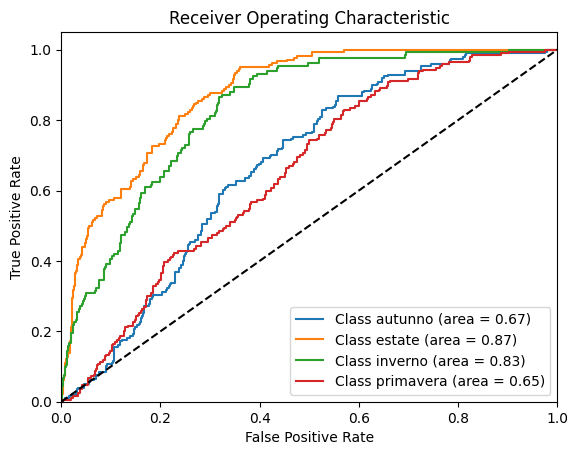

In [ ]:
# Funzione per plottare la curva ROC
def plot_roc(model, dataloader, num_classes):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {dataloaders['train'].dataset.classes[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

plot_roc(model, dataloaders['test'], num_classes)

### Matrice di Confusione

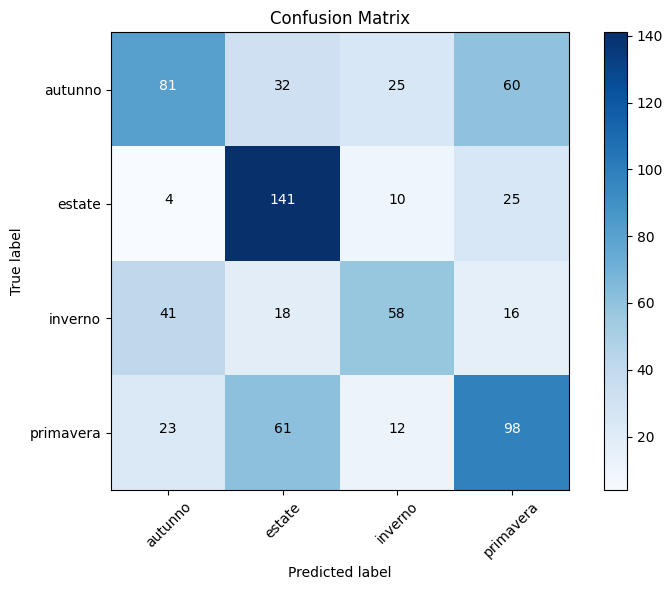

In [ ]:
# Funzione per stampare e visualizzare la matrice di confusione senza normalizzazione
def plot_confusion_matrix(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    # Stampa della matrice di confusione
    classes = dataloader.dataset.classes
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Esempio di utilizzo dopo aver addestrato il modello
plot_confusion_matrix(model, dataloaders['test'])


### Salvataggio del modello

In [ ]:
# Specifica il percorso del file di salvataggio del modello
save_path = os.path.join(save_dir, 'armocromia_resnet50_2.pth')

# Salvataggio del modello
torch.save(model.state_dict(), save_path)

print(f'Model saved to {save_path}')

Model saved to c:\Users\dswal\Desktop\prova\model_fine_tuning\armocromia_resnet50_2.pth
